In [1]:
# import dependencies
import os, re, time, json 
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from functools import reduce
from sklearn.datasets import make_blobs

In [2]:
IMG_HEIGHT = 512
IMG_WIDTH = 512

In [3]:

def get_image_feature(image):
    temp = image # divide by 255 to get in fraction
    mn = temp.sum(axis=0).sum(axis=0)/(temp.shape[0]*temp.shape[1])
    return mn/np.linalg.norm(mn, ord=None) # taking 2nd norm to scale vector

def get_image(name, folder, color_space='rgb'):
    filepath = os.path.join(folder, name)
    # img = Image.open(filepath)
    # read imread as rgb
    img = cv2.imread(filepath, cv2.IMREAD_COLOR)
    # convert to rgb color space
    if color_space == 'rgb':
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    elif color_space == 'gray':
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # resize image to 254x254
    img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    # convert to rgb color space
    return np.array(img)


def get_images(directoryName, color_space='rgb'):
    directory = os.fsencode(directoryName)
    images = []
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.endswith(".jpg") or filename.endswith(".jpeg") or filename.endswith(".png"):
            image = get_image(filename, directoryName, color_space)
            images.append(image)
            continue
        else:
            continue
    return np.array(images)

In [30]:
from sklearn.mixture import GaussianMixture

def low_light(image):
    # Convert to HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Apply histogram equalization to V channel
    hsv[:, :, 2] = cv2.equalizeHist(hsv[:, :, 2])

    # Apply median filter to V channel
    hsv[:, :, 2] = cv2.medianBlur(hsv[:, :, 2], 5)

    # Convert back to RGB
    img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    return img

def apply_hsv_rule(image):
    img = image.copy()

    # Convert to HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # Split channels
    h, s, v = cv2.split(hsv)

    # transform hsv to 0-1 range
    h = h/255
    s = s/255
    v = v/255

    # get rgb component
    r, g, b = cv2.split(image)

    # Define rules
    mask = (h>=0.13) & (h<0.46) & (s>=0.1) & (s<=0.34) & (v>=0.96) & (v<=1) & (r>=g) & (g>b) & (r>180) & (g>130) & (b<120)

    # Apply mask
    img[mask] = 255

    img[~mask] = 0

    return img

def apply_ycbcr_rule(image):
    img = image.copy()

    # Convert to YCbCr
    ycbcr = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)

    # Split channels
    y, cb, cr = cv2.split(ycbcr)

    # get rgb component
    r, g, b = cv2.split(image)

    # Define rules
    mask = (y>cr) & (cr>=cb) & (y>=180) & (y<210) & (cb>=80) & (cb<=120) & (cr>=80) & (cr<=139) & (r>=g) & (g>b) & (r>190) & (g>110) & (b<180)

    # Apply mask
    img[mask] = 255

    img[~mask] = 0

    return img

def apply_rgb_rule(image):
    img = image.copy()

    # Split channels
    r, g, b = cv2.split(image)

    # Define rules
    mask = (r>g) & (g>b) & (r>200) & (g>130) & (b<120)

    # Apply mask
    img[mask] = 255

    img[~mask] = 0

    return img

def segment_images(images):
    result = []
    for image in images:
        cpy_img = image.copy()

        # apply hsv rules
        ycbcr_img = apply_ycbcr_rule(cpy_img)
        hsv_img = apply_hsv_rule(cpy_img)
        rgb_img = apply_rgb_rule(cpy_img)

        # combine all masks using or operator 
        ycbcr_img = np.logical_or(ycbcr_img, hsv_img)
        ycbcr_img = np.logical_or(ycbcr_img, rgb_img)

        # mask original image
        cpy_img[~ycbcr_img] = 0
        cpy_img[ycbcr_img] = 255
        
        result.append(cpy_img)

    return np.array(result)  

def segment_image(image):
    cpy_img = image.copy()

    # apply hsv rules
    ycbcr_img = apply_ycbcr_rule(cpy_img)
    hsv_img = apply_hsv_rule(cpy_img)
    rgb_img = apply_rgb_rule(cpy_img)

    # combine all masks using or operator 
    ycbcr_img = np.logical_or(ycbcr_img, hsv_img)
    ycbcr_img = np.logical_or(ycbcr_img, rgb_img)

    # mask original image
    cpy_img[~ycbcr_img] = 0

    return cpy_img
        

In [77]:
def morphological_operations(image, kernel_size, iterations):
    # Create a kernel for morphological operations
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size)

    # Perform closing operation
    closed_image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel, iterations=iterations)

    # Perform dilation operation
    dilated_image = cv2.dilate(closed_image, kernel, iterations=iterations)

    # close holes
    dilated_image = cv2.morphologyEx(dilated_image, cv2.MORPH_CLOSE, kernel, iterations=iterations)


    return dilated_image

In [54]:
def combine_segmentations(segmentation1, segmentation2, threshold):
    segmentation1 = cv2.cvtColor(segmentation1, cv2.COLOR_RGB2GRAY)
    combined_segmentation = np.zeros(segmentation1.shape, dtype=np.uint8)
    
    for i in range(segmentation1.shape[0]):
        for j in range(segmentation1.shape[1]):
            if segmentation1[i, j] > 0 and segmentation2[i, j] > 0:
                probability1 = float(segmentation1[i, j]) / 255.0
                probability2 = float(segmentation2[i, j]) / 255.0
                combined_probability = probability1 * probability2

                if combined_probability > threshold:
                    combined_segmentation[i, j] = 255  # Set the pixel to white (255) for the combined segmentation
                else:
                    combined_segmentation[i, j] = 0    # Set the pixel to black (0) for the combined segmentation
                    
    return combined_segmentation


In [120]:
def combine_segmentations_and(segmentation1, segmentation2, threshold):
    segmentation1 = cv2.cvtColor(segmentation1, cv2.COLOR_RGB2GRAY)
    combined_segmentation = np.zeros(segmentation1.shape, dtype=np.uint8)

    for i in range(segmentation1.shape[0]):
        for j in range(segmentation1.shape[1]):
                if segmentation1[i, j] > 0 and segmentation2[i, j] > 0:
                    combined_segmentation[i, j] = 255  # Set the pixel to white (255) for the combined segmentation
                else:
                    combined_segmentation[i, j] = 0    # Set the pixel to black (0) for the combined segmentation
    
    return combined_segmentation

In [68]:
def combine_segmentations_or(segmentation1, segmentation2, threshold):
    segmentation1 = cv2.cvtColor(segmentation1, cv2.COLOR_RGB2GRAY)
    combined_segmentation = np.zeros(segmentation1.shape, dtype=np.uint8)


    # for i in range(segmentation1.shape[0]):
    #     for j in range(segmentation1.shape[1]):
    #             if segmentation1[i, j] > 0 or segmentation2[i, j] > 0:
    #                 combined_segmentation[i, j] = 255  # Set the pixel to white (255) for the combined segmentation
    #             else:
    #                 combined_segmentation[i, j] = 0    # Set the pixel to black (0) for the combined segmentation
    
    return segmentation1


In [84]:
# pick last 5 images from each class for training
from sklearn.mixture import GaussianMixture

# get the rgb values of the images+
bow_image = np.vstack([image.reshape(-1, image.shape[-1]) for image in get_images('./dataset_bow/')])

gmm = GaussianMixture(covariance_type='full', n_components=2, verbose=1)
fit = gmm.fit(bow_image)

Initialization 0
  Iteration 10
Initialization converged: True


In [96]:
test_img = get_images('./visifire-full/img/', color_space='rgb')
test_gt = get_images('./visifire-full/gt', color_space='gray')

# masked = segment_images(test_img)

In [122]:
def get_prediction(image, gmm):
    masked = segment_image(image)

    masked = morphological_operations(masked, (3, 3), 2)

    # convert image hsv 
    cluster = gmm.predict(image.reshape(IMG_HEIGHT*IMG_WIDTH, 3))

    cluster = cluster.reshape(IMG_HEIGHT, IMG_WIDTH)

    # get the mask for the cluster, set the cluster to 255 and rest to 0
    mask = np.where(cluster==1, 255, 0).astype('uint8')

    final_segmented = combine_segmentations_and(masked, mask,0.5)
    
    kernel_size = (3, 3)  # Adjust the kernel size as per your requirements
    iterations = 2
    
    final_mask = morphological_operations(final_segmented, kernel_size, iterations)

    return final_mask

In [123]:
print(len(test_img))

2544


In [124]:
predictions = [get_prediction(image, fit) for image in test_img]

In [125]:
def calculate_iou(masks, gt_masks):
    iou = []
    for i in range(len(masks)):
        intersection = np.logical_and(masks[i], gt_masks[i])
        # plot mask and gt mask
        union = np.logical_or(masks[i], gt_masks[i])
        iou.append(np.sum(intersection) / (np.sum(union) + 1e-6))
    return np.mean(iou)

iou = calculate_iou(predictions, test_gt)
print(iou)


0.24578682353284378


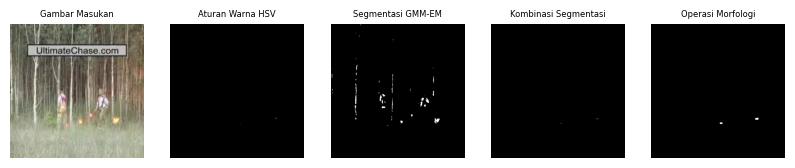

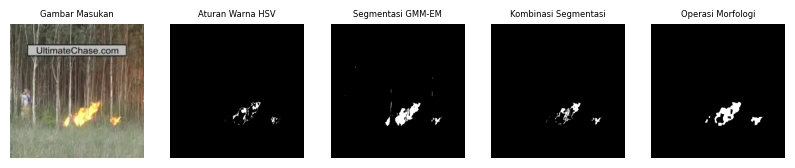

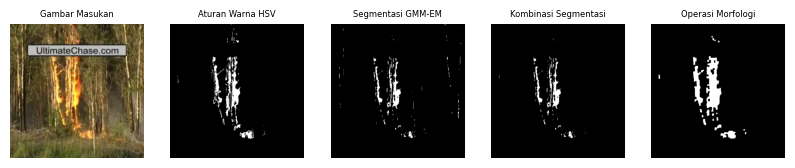

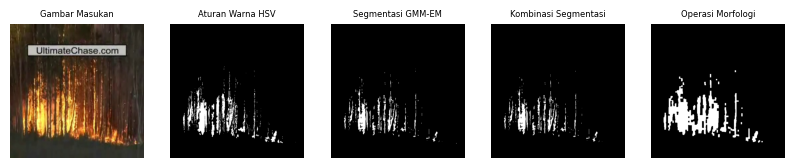

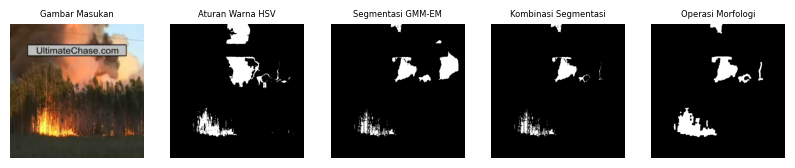

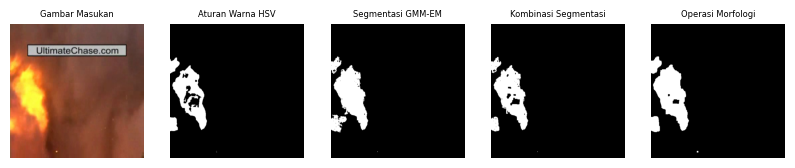

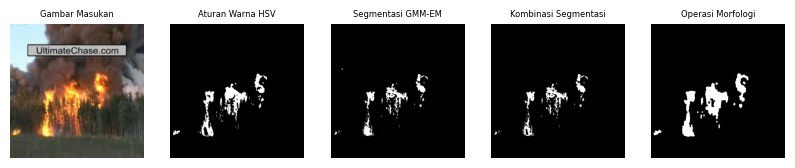

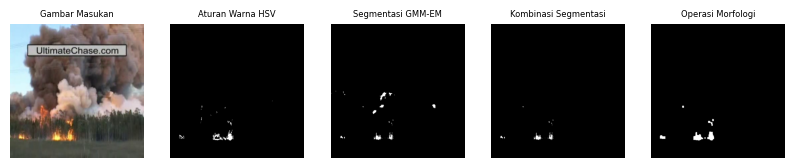

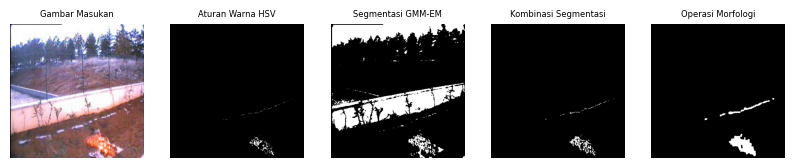

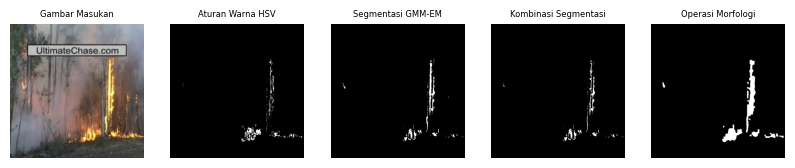

In [126]:
test_visual = get_images('./visualization_test_data', color_space='rgb')

masked2 = segment_images(test_visual)
for i in range(len(masked2)):
    newdata = masked2[i].reshape(IMG_HEIGHT*IMG_WIDTH, 3)

    cluster = fit.predict(test_visual[i].reshape(IMG_HEIGHT*IMG_WIDTH, 3))

    cluster = cluster.reshape(IMG_HEIGHT, IMG_WIDTH)
    fig = plt.figure(figsize=(10, 10))
    plt.rcParams.update({'font.size': 5})
    plt.subplot(1, 5, 1)
    plt.title('Gambar Masukan')
    plt.imshow(test_visual[i])
    plt.axis('off')

    plt.subplot(1, 5, 2)
    plt.title('Aturan Warna HSV')
    plt.imshow(masked2[i])
    plt.axis('off')

    kernel_size = (3, 3)  # Adjust the kernel size as per your requirements
    iterations = 2
    
    masked2[i] = morphological_operations(masked2[i], kernel_size, iterations)

    plt.subplot(1, 5, 3)
    plt.title('Segmentasi GMM-EM')
    # set font size
    plt.imshow(cv2.cvtColor(fit.means_[cluster].reshape(IMG_HEIGHT, IMG_WIDTH, 3).astype(np.uint8), cv2.COLOR_RGB2GRAY), cmap='gray')
    plt.axis('off')

    mask = np.where(cluster==1, 255, 0).astype('uint8')

    final_segmented = combine_segmentations_and(masked2[i], mask, 0.5)
    plt.subplot(1, 5, 4)
    plt.title('Kombinasi Segmentasi')
    plt.imshow(final_segmented, cmap='gray')
    plt.axis('off')

    kernel_size = (3, 3)  # Adjust the kernel size as per your requirements
    iterations = 2
    final_segmented = morphological_operations(final_segmented, kernel_size, iterations)
    
    
    plt.subplot(1, 5, 5)
    plt.title('Operasi Morfologi')
    plt.imshow(final_segmented, cmap='gray')
    plt.axis('off')